In [1]:
%matplotlib nbagg
import plotly.offline as py
py.init_notebook_mode(connected=True)
from ipywidgets import interact, interactive, FloatSlider, IntSlider, HBox, VBox, Tab, Layout, Box, Label, BoundedFloatText, Dropdown
import ipywidgets as widgets
from IPython.display import display, HTML
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
from cycler import cycler
import numpy as np
import pandas as pd
from collections import OrderedDict


display(HTML("<style>.container { width:100% !important; }</style>"))
plt.style.use('ggplot')



### Functions to build the experiment

In [3]:
# Define a fnc to create a sample error matrix with a given set of properties

def calculate_weights(nclass, weight_dist, start_value):
    """Returns a weight distribution for given number of classes and a starting
    point for the sequence. The weight distributions are 'linear' and 
    'geometric'. The weights are calculated using the interval from 'start_value' to 1. 
    That is, a start value close to 0 will give more unbalanced weights, and
    a value of 1 will give an equal distribution for any case. 
    'geometric' requires a starting point larger than zero.
    
    """
    # Create weights
    if weight_dist == 'linear':
        sequence = np.linspace(start_value,1, nclass)
    elif weight_dist == 'geometric':
        sequence = np.geomspace(start_value,1, nclass)
    
    wh = (1 * sequence) / sequence.sum()
    
    # Invert weights to have bigger ones at the beginning
    wh = -np.sort(-wh)
    
    return wh


def adjust_values(values, target_sum):
    """Calculates the sum of the ceiling values and substracts from the
    largest value to match the desired total sum of the elements"""
    
    rounded_vals = np.ceil(values)
    totsum= rounded_vals.sum()

    while True:
        totsum = rounded_vals.sum()
        maxind = np.argmax(rounded_vals)
        if (totsum - target_sum) == 0:
            break
        else:
            rounded_vals[maxind] -= 1

    return rounded_vals        


def check_weights(nclass, weights):
    """Check if the number of weights equals number of classes and
    if they add up to 1. 
    """
    return (len(weights) == nclass) & (round(weights.sum(),3) == 1.0)


def create_error_matrix(nclass, str_wh, samp_wh, tot_sample_size):
    """
    Create artificial error matrix based on number of classes, a strata weight distribution,
    total sample size and how to distribute it across strata. Other arguments if weights are 
    specified manually. 
    """
        
    # Check that weights add to 1 and the count matches the number of classes
    if not check_weights(nclass, str_wh):
        print("Error: Number of strata weights must be equal to number of classes and the sum add to 1")
        return
    
    if not check_weights(nclass, samp_wh):
        print("Error: Number of strata weights must be equal to number of classes and the sum add to 1")
        return
    
    
    # Create sample size per stratum, proportional to weight
    # Adjust sizes for the sum to match the input total
    ni = str_wh * tot_sample_size
    ni = adjust_values(ni, tot_sample_size)
    
    # Create perfect confusion matrix and modify it based on the sample weights
    pcmat = np.zeros((nclass, nclass))
    np.fill_diagonal(pcmat, ni)
    diag = np.diag_indices(nclass)

    # Get redistributed counts    
    out_cm = [samp_wh * n for n in ni]
    # Shift them to match the structure of the matrix
    out_cm = [np.roll(a, b) for a, b in zip(out_cm, diag[0])]
    # Adjust values for the sum to match the total sample size
    out_cm = [adjust_values(a, b) for a, b in zip(out_cm, ni)]
    # Stack and calculate sum for verification purposes
    out_cm = np.vstack(out_cm)

    out_cm_sum = out_cm.sum(axis=1) # ADD CHECK!

    # Passing them as list of tuple preserves the order with OrderedDict
    return OrderedDict([('conf_mat', out_cm), ('ni', ni), ('str_wh', str_wh), ('samp_wh', samp_wh), ('rowsum', out_cm_sum)])


# Calculate and add multiple items to the dictionary
def run_calculations(d, total_area):
    """Takes a dictionary with confusion matrix, weights, sample counts, and a total area (in ha)
    and runs all the calculations necessary for the experiments
    """ 
    d['conf_mat_prop'] = (d['conf_mat'] * d['str_wh']) / d['ni']
    d['area_prop'] = d['conf_mat_prop'].sum(axis=0) 
    d['area_ha'] =  d['area_prop']* total_area
    d['area_prop_se'] = np.sqrt(np.sum((d['str_wh'] * d['conf_mat_prop'] - d['conf_mat_prop']**2) / (d['ni'] - 1), axis=0))
    d['area_ci'] = d['area_prop_se'] * 1.96 * total_area
    d['margin_error'] = d['area_ci'] / d['area_ha']
    d['usr_acc'] = np.diag(d['conf_mat_prop'] / d['conf_mat_prop'].sum(axis=1)) * 100
    d['prod_acc'] = np.diag(d['conf_mat_prop'] / d['conf_mat_prop'].sum(axis=0)) * 100
    d['tot_acc'] = np.diag(d['conf_mat_prop']).sum()
    
    return d


def create_dataframe(cm_dict, keys_list):
    """Assemble an easy to view dataframe from a list of elements in a dictionary.
    They should match dimensions. For now it just assumes that the first key passed is
    the confusion matrix, and checks by name only...
    """
    
    if not(keys_list[0] == 'conf_mat' or keys_list[0] == 'conf_mat_prop'):
        print('Error: First element must be confusion matrix')
        return
    
    # Create pandas df to store everything
    colnames = ['ref{}'.format(i+1) for i in range(cm_dict[keys_list[0]].shape[0])]
    rownames = ['map{}'.format(i+1) for i in range(cm_dict[keys_list[0]].shape[0])]
    
    # Assemble df and rename cols and rows
    df = pd.concat([pd.DataFrame(cm_dict.get(i)) for i in keys_list], axis=1)
    colnames.extend(keys_list[1:])
    df.columns = colnames
    
    rownames_dict = {i: v for i,v in enumerate(rownames)}
    df.rename(rownames_dict, inplace=True)
    
    
    return df

# def create_tidy_dataframe(cm_dict, keys_list):
#     """ Assemble a tidy dataframe that can be used more easily with seaborn and other 
#     packages for analysis and visualization
#     """
    
#     # Create pandas df to store everything
#     refnames = ['ref{}'.format(i+1) for i in range(cm_dict[keys_list[0]].shape[0])]
#     mapnames = ['map{}'.format(i+1) for i in range(cm_dict[keys_list[0]].shape[0])]
#     df = 
    
# Wrap funcs in a single one

def run_experiment(numclass, str_w_dist, samp_w_dist, str_w_val, samp_w_val, sample_size, total_area):
    """ Run experiement and return a single dictionary with all the relevant results """
    str_weights =  calculate_weights(numclass, str_w_dist, str_w_val)
    sample_weights = calculate_weights(numclass, samp_w_dist, samp_w_val)
    out_dict = create_error_matrix(numclass, str_weights, sample_weights, sample_size)
    out_dict = run_calculations(out_dict, total_area)
    return out_dict

def create_plot_dict(d, keys_list):
    """ Take a results dictionary and return a dictionary with arrays formatted
    so that they can be readily plotted
    """
    out_dict = OrderedDict()
    for k in keys_list:
        out_dict[k] = np.vstack([d.get(x)[k] for x in d.keys()])
        
    return out_dict

### Run!

In [4]:
# Define global variables
total_area = 100000
sample_size = 1000
df_key_list = ['conf_mat_prop', 'ni', 'str_wh', 'prod_acc', 'area_ha', 'area_ci','margin_error']

In [5]:
# Single
test_weights = calculate_weights(4, 'geometric', 0.1)
dts1 = create_error_matrix(4, test_weights, test_weights, sample_size)
dts1
create_dataframe(dts1, list(dts1.keys()))

,ref1,ref2,ref3,ref4,ni,str_wh,samp_wh,rowsum
map1,313.0,147.0,68.0,32.0,560.0,0.561923,0.561923,560.0
map2,15.0,145.0,69.0,32.0,261.0,0.260822,0.260822,261.0
map3,15.0,7.0,68.0,32.0,122.0,0.121063,0.121063,122.0
map4,15.0,7.0,4.0,31.0,57.0,0.056192,0.056192,57.0


### Interactive plots - vary sample distribution for all values of strata weight

In [6]:
numclass=IntSlider(min=2, max=10, value=4, description='Number of classes', continuous_update=False)
sample_size=IntSlider(min=1000, max=200000, value=100000, description='Total sample size', continuous_update=False)
total_area=IntSlider(min=1000, max=200000, value=100000, description='Total area [ha]', continuous_update=False)
samp_w_val=FloatSlider(min=0, max=1.0, value=1, description='Sample weight balance', continuous_update=False, readout_format='.4f')
samp_w_dist = Dropdown(options={'linear': 'linear', 'geometric': 'geometric'}, value='linear', description='Sample weight distribution:')
str_w_dist = Dropdown(options={'linear': 'linear', 'geometric': 'geometric'}, value='linear', description='Strata weight distribution:')
weights_text = Label(layout=Layout(width='100%'), continuous_update=False)



def interact_plot(numclass, total_area, sample_size, str_w_dist, samp_w_dist, samp_w_val):
    """Plots all vars coming from the formatted results lis agains each other. 
    For each of those arrays, rows are the observations and columns are different classes. 
    Requires number of classes, total area, distribution of strata weights, distribution of
    sample weights, and value to calculate sample weights.
    """
    
    results_dict = OrderedDict()

    # Calculate all levels of strata weights for a single value of sample weights
    for i in np.linspace(0.001, 1, 20):
        results_dict[i] = run_experiment(numclass, str_w_dist, samp_w_dist, i, samp_w_val, sample_size, total_area)
     
    # Make this block more generalizable    
    plot_d = create_plot_dict(results_dict, ['str_wh', 'samp_wh','prod_acc', 'margin_error', 'area_ci', 'area_prop'])
    weights_text.value = "Actual weights: {}".format(str(np.round(plot_d['samp_wh'][0,:], 2)))
    # We want to plot everything against the FIRST weight (e.g. the weight of the dominant class (stratum), or the
    # weight of the correct class (sample diagonals))
    plot_d['str_wh'] = plot_d['str_wh'][:, 0]
    
    key_list = list(plot_d.keys())
    nvars = len(key_list)
    matplotlib.rcParams['figure.figsize'] = (9.0, 9.0)
    colors = [plt.cm.Set1(i) for i in range(numclass)]    
    plt.rc('axes', prop_cycle=(cycler('color', colors)))
    f, ax = plt.subplots(nvars, nvars, sharex='col', sharey='row')
    
    for i,k1 in enumerate(key_list):
        ax[nvars-1,i].set_xlabel(key_list[i])
        for j,k2 in enumerate(key_list[::-1]):
            ax[j, i].plot(plot_d[k1], plot_d[k2])
            ax[j,0].set_ylabel(key_list[::-1][j])
    
    f.legend([l for l in ax[0,0].lines],
             ["Class {} ".format(i+1) for i in range(numclass)],
              loc='upper right', fontsize=12)
    
    f.suptitle("Fixed sample weight, all strata weights")
           
    return results_dict


intplot = interactive(interact_plot, numclass=numclass, total_area=total_area, sample_size=sample_size,
                      str_w_dist=str_w_dist, samp_w_dist=samp_w_dist, samp_w_val=samp_w_val, continuous_update=False)
controlbox = VBox([VBox(intplot.children[0:6]), weights_text])
plotbox = VBox([intplot.children[-1]], layout=Layout(width='90%'))
iplot = HBox([plotbox, controlbox])
display(iplot)

In [ ]:
# CONVERT OUTPUT TO A SINGLE PANDAS DF AND USE PANDAS.TOOLS.PLOTTING



In [ ]:
# Temporary fix to get any confusion matrix we want.
create_dataframe(intplot.result[list(intplot.result.keys())[0]], ['conf_mat', 'ni', 'str_wh', 'prod_acc', 'area_ha', 'area_prop'])

In [ ]:
#intplot.result
plt.close("all")

- Ignore sample weight column. High sample vals to make plots smoother
- Show initial state for 'linear' and 'geometric' strata weights
- More dominant class, higher accuracy for that class. The more dominant (geometric), the starker the difference.
- Almost perfect confusion matrix (geometric 0.001) makes the margin of error much bigger as the strata weight of the dominant class gets higher.
- In that same scenario (both geometric), it only takes 1% of the total samples in the diagonal to make the prod. acc. fall to 50% when the strata weight is around 75%.
- Then if we look at margin_error vs accuracy, we could determine that in order to get a margin of error in the lower numbers, we need to achieve really high accuracy. 
- Larger CI and margins of error are obtained when area is large, total sample is small (e.g. 1000) and classes are very unbalanced (both geometric, 0.0001)
- Margin of error  can be seen simply as the proportion of class area that constitutes the CI. 
- For example, if we want the margin of error to be just 10%, that value is associated with a producer's accuracy of around 80%, for the example described previously.
- For most cases, small margins of error can only be achieved with accuracies above 50%

### Interactive plots - vary strata distribution for all values of sample weight

In [7]:
numclass=IntSlider(min=2, max=10, value=4, description='Number of classes', continuous_update=False)
sample_size=IntSlider(min=1000, max=200000, value=100000, description='Total sample size', continuous_update=False)
total_area=IntSlider(min=1000, max=200000, value=100000, description='Total area [ha]', continuous_update=False)
str_w_val=FloatSlider(min=0, max=1.0, value=1, description='Strata weight balance', continuous_update=False, readout_format='.4f')
samp_w_dist = Dropdown(options={'linear': 'linear', 'geometric': 'geometric'}, value='linear', description='Sample weight distribution:')
str_w_dist = Dropdown(options={'linear': 'linear', 'geometric': 'geometric'}, value='linear', description='Strata weight distribution:')



def interact_plot(numclass, total_area, sample_size, str_w_dist, samp_w_dist, str_w_val):
    """Plots all vars coming from the formatted results lis agains each other. 
    For each of those arrays, rows are the observations and columns are different classes. 
    Requires number of classes, total area, distribution of strata weights, distribution of
    sample weights, and value to calculate strata weights."""
    
    results_dict = OrderedDict()

    # Calculate all levels of strata weights for a single value of sample weights
    for i in np.linspace(0.001, 1, 20):
        results_dict[i] = run_experiment(numclass, str_w_dist, samp_w_dist, str_w_val, i, sample_size, total_area)

    # Make this block more generalizable    
    plot_d = create_plot_dict(results_dict, ['str_wh', 'samp_wh','prod_acc', 'margin_error', 'area_ci', 'area_prop'])
    weights_text.value = "Actual weights: {}".format(str(np.round(plot_d['str_wh'][0,:], 2)))
    # We want to plot everything against the FIRST weight (e.g. the weight of the dominant class (stratum), or the
    # weight of the correct class (sample diagonals))
    plot_d['samp_wh'] = plot_d['samp_wh'][:, 0]
    
    key_list = list(plot_d.keys())
    nvars = len(key_list)
    matplotlib.rcParams['figure.figsize'] = (9.0, 9.0)
    colors = [plt.cm.Set1(i) for i in range(numclass)]    
    plt.rc('axes', prop_cycle=(cycler('color', colors)))
    f, ax = plt.subplots(nvars, nvars, sharex='col', sharey='row')
    
    for i,k1 in enumerate(key_list):
        ax[nvars-1,i].set_xlabel(key_list[i])
        for j,k2 in enumerate(key_list[::-1]):
            ax[j, i].plot(plot_d[k1], plot_d[k2])
            ax[j,0].set_ylabel(key_list[::-1][j])
    
    f.legend([l for l in ax[0,0].lines],
             ["Class {0} ".format(i+1) for i in range(numclass)],
              loc='upper right', fontsize=12)
    f.suptitle("Fixed strata weight, all sample weights")
    #plt.tight_layout()
    
    return results_dict
            
intplot = interactive(interact_plot, numclass=numclass, total_area=total_area, sample_size=sample_size,
                      str_w_dist=str_w_dist, samp_w_dist=samp_w_dist, str_w_val=str_w_val, continuous_update=False)
controlbox = VBox([VBox(intplot.children[0:6]), weights_text])
plotbox = VBox([intplot.children[-1]], layout=Layout(width='90%'))
iplot = HBox([plotbox, controlbox])
display(iplot)

In [ ]:
# Temporary fix to get any confusion matrix we want.
#create_dataframe(intplot.result[list(intplot.result.keys())[6]], ['conf_mat_prop', 'ni', 'str_wh'])

/home/paulo/miniconda3/envs/plants/lib/python3.5/site-packages/ipykernel_launcher.py:101: RuntimeWarning:

divide by zero encountered in true_divide

/home/paulo/miniconda3/envs/plants/lib/python3.5/site-packages/ipykernel_launcher.py:101: RuntimeWarning:

invalid value encountered in true_divide



<IPython.core.display.Javascript object>


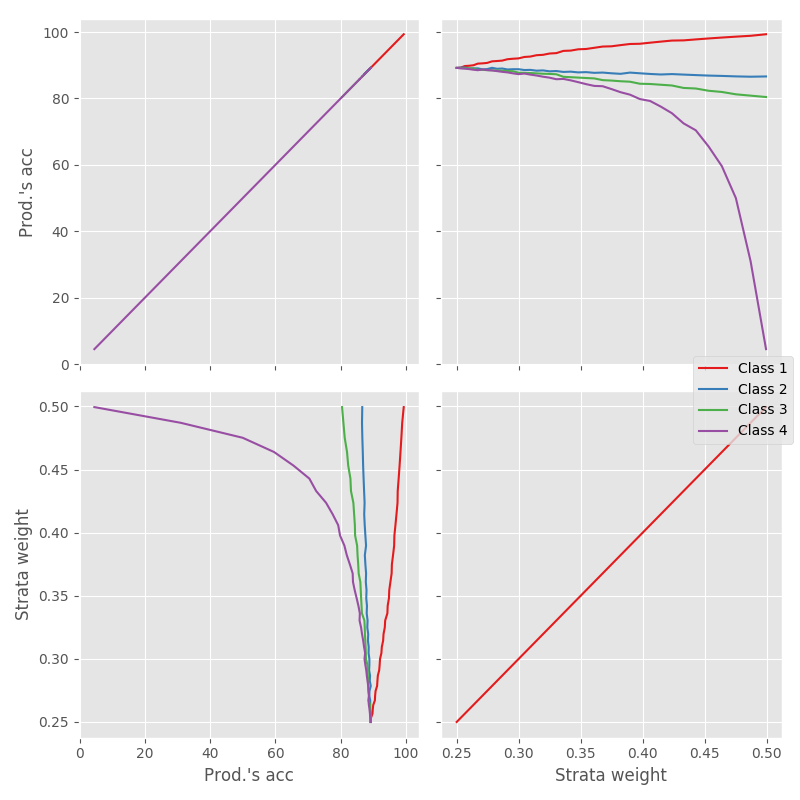

In [8]:
# OLD WAY, KEEP FOR TESTING
# Define global variables
total_area = 100000
sample_size = 1000
df_key_list = ['conf_mat_prop', 'ni', 'str_wh', 'prod_acc', 'area_ha', 'area_ci','margin_error']

results_dict = OrderedDict()

for i in np.linspace(0.001, 1, 40):
    results_dict[i] = run_experiment(4, 'linear', 'geometric', i, 0.001, sample_size,total_area)

prod_accs = np.vstack([results_dict.get(x)['prod_acc'] for x in results_dict.keys()])
me = np.vstack([results_dict.get(x)['margin_error'] for x in results_dict.keys()])
ci_width = np.vstack([results_dict.get(x)['area_ci'] for x in results_dict.keys()])
samp_w = np.vstack([results_dict.get(x)['samp_wh'] for x in results_dict.keys()])
str_w = np.vstack([results_dict.get(x)['str_wh'] for x in results_dict.keys()])

def plot_multi(varlist, varnames, nclass):
    """Plots all vars in a list against each other. Rows are assumed to be the
    observations and columns are different classes. 
    Requires a list of vars, list of names for those vars, and number of classes.
    """
    
    nvars = len(varlist)
    matplotlib.rcParams['figure.figsize'] = (8.0, 8.0)
    colors = [plt.cm.Set1(i) for i in range(nclass)]    
    plt.rc('axes', prop_cycle=(cycler('color', colors)))
    f, ax = plt.subplots(nvars, nvars, sharex='col', sharey='row')
    
    for i,v1 in enumerate(varlist):
        ax[nvars-1,i].set_xlabel(varnames[i])
        for j,v2 in enumerate(varlist):
            ax[j, i].plot(v1,v2)
            ax[j,0].set_ylabel(varnames[j])
    
    #print(ax[0,0].lines)
    f.legend([l for l in ax[0,0].lines], ["Class {}".format(i+1) for i in range(nclass)], loc=7)
    plt.tight_layout()
            

plot_multi([prod_accs, str_w[:,0]], ["Prod.'s acc", "Strata weight"], 4)

## SLIDES

# Area estimation, accuracies and uncertainty

### Motivation:

- Need to understand the relationship between map accuracy and area uncertainty, among others.

- Need to disentangle the effect of multiple factors that influence area uncertainty.

- Need to analyze these things in a systematic way to avoid reaching false conclusions.


### The basics

A "perfect" confusion matrix would look like this:

In [ ]:
strata_weights = calculate_weights(4, 'geometric', 1)
perfect_weights = np.array([1.,0,0,0])
dts1 = create_error_matrix(4, strata_weights, perfect_weights, 800)
dst1 = run_calculations(dts1, total_area)
df1 = create_dataframe(dts1, ['conf_mat', 'ni', 'str_wh'])

In [ ]:
df1

A slightly less than perfect matrix would look more like this.

In [ ]:
strata_weights = calculate_weights(4, 'linear', 0.5)
sample_weights = calculate_weights(4, 'geometric', 0.01)
dts1 = create_error_matrix(4, strata_weights, sample_weights, 800)
dst1 = run_calculations(dts1, total_area)
df2 = create_dataframe(dts1, ['conf_mat', 'ni', 'str_wh'])


In [ ]:
df2

How to describe how balanced/unbalanced these matrices are? How to characterize them?

### Proposed solution

Creating the tables using two sets of weights:

1. Strata weights as they would come from the map (i.e row distribution)

2. 'Sample weights' to convert a perfect confusion matrix into a more realistic one (i.e. column distribution)

e.g. If I want to emulate 4 strata with equal area weights and 100% accurate

In [ ]:
strata_weights = calculate_weights(4, 'linear', 1)
strata_weights


In [ ]:
perfect_weights = np.array([1.,0,0,0])
dts1 = create_error_matrix(4, strata_weights, perfect_weights, 800)
dst1 = run_calculations(dts1, total_area)
create_dataframe(dts1, ['conf_mat', 'ni', 'str_wh'])

But if I want to "spread" the diagonal count into the other cells, so that the matrix 
is less than perfect:

In [ ]:
imperfect_weights = calculate_weights(4, 'linear', 0)
imperfect_weights

In [ ]:
dts1 = create_error_matrix(4, strata_weights, imperfect_weights, 800)
dst1 = run_calculations(dts1, total_area)
create_dataframe(dts1, ['conf_mat', 'ni', 'str_wh'])

Here we have 4 map classes, each with the same weight, but the reference counts are spread
so that ~50% remain in the diagonal, 30% in the next cell, 16% in the next and none in the last.

This is done for every row.

In that way, any weight distribution can be defined with a single parameter, a number between 0 and 1:

- Values close to 0 give a more unbalanced weight distribution

- Values close to 1 give a more even weight distribution

### The results

Multiple confusion matrices can be created, varying one of the weights at a time and recalculating accuracies, areas, etc, for every class.

E.g. create 10 matrices, from very balanced to very unbalanced. Plot the weights of the dominant class against other variables.

- Plot producer's accuracy, margin of error, confidence interval for the whole range of strata weights of the DOMINANT class, for a given sample weight

- Same, but for the whole range of sample weight, for a given strata weight.

For example, plot producer's accuracy VS the entire range of strata weights of the DOMINANT class, 
when the confusion matrix is almost perfect (90% of the samples are in the diagonal, 1% in the each of the other cells)

In [ ]:
calculate_weights(4, 'geometric', 0.001)

In [ ]:
plot_multi([prod_accs, str_w[:,0]], ["Prod.'s acc", "Strata weight"], 4)